In [1]:
from random import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain
from random import uniform
import random
import warnings
from statistics import mean

In [2]:
def readNetworkFromGml(file):
    gmlNet = nx.read_gml(file, label="id")
    mat = nx.adjacency_matrix(gmlNet)
    matrix = [[0] * len(gmlNet.nodes) for _ in range(len(gmlNet.nodes))]
    tmp = mat.nonzero()
    for i in range(len(tmp[0])):
        matrix[tmp[0][i]][tmp[1][i]] = 1
    net = {
        'noNodes': len(gmlNet.nodes),
        'mat': matrix,
        'noEdges': len(gmlNet.edges),
        'degrees': [degree[1] for degree in gmlNet.degree()]
    }

    return net

In [4]:
# 1. Dolphins
G = nx.read_gml("data/real/dolphins/dolphins.gml", label='id')

In [5]:
# Calcularea partajării în comunități
partition = community_louvain.best_partition(G)

In [6]:
# Afișarea rezultatului
print("Comunitățile identificate:")
print(partition)

Comunitățile identificate:
{0: 0, 1: 1, 2: 0, 3: 3, 4: 2, 5: 1, 6: 1, 7: 1, 8: 3, 9: 1, 10: 0, 11: 2, 12: 4, 13: 1, 14: 4, 15: 2, 16: 4, 17: 1, 18: 2, 19: 1, 20: 0, 21: 2, 22: 1, 23: 2, 24: 2, 25: 1, 26: 1, 27: 1, 28: 0, 29: 2, 30: 0, 31: 1, 32: 1, 33: 4, 34: 4, 35: 2, 36: 3, 37: 4, 38: 4, 39: 3, 40: 4, 41: 1, 42: 0, 43: 4, 44: 0, 45: 2, 46: 4, 47: 0, 48: 1, 49: 4, 50: 4, 51: 2, 52: 4, 53: 4, 54: 1, 55: 2, 56: 1, 57: 1, 58: 4, 59: 3, 60: 1, 61: 4}


In [7]:
# Desenarea grafului cu noduri colorate în funcție de comunitate
pos = nx.spring_layout(G)
colors = [partition[node] for node in G.nodes()]

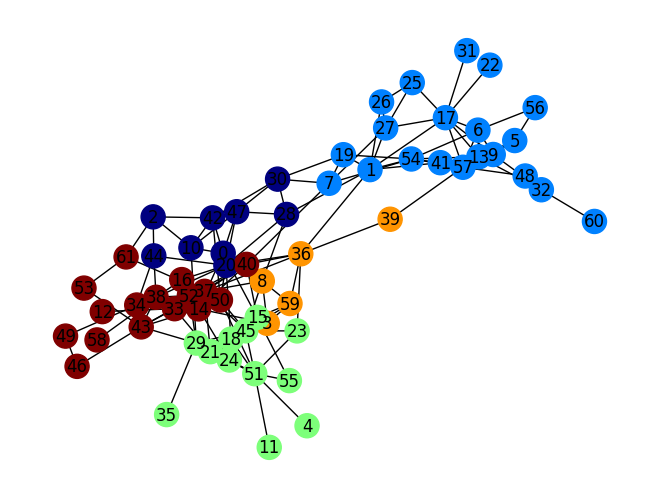

In [8]:
nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.jet)
plt.show()

In [9]:
# Calcularea modularității
modularity = community_louvain.modularity(partition, G)
print(f"Modularitatea: {modularity}")

Modularitatea: 0.5285194414777896


In [10]:
# Transformarea dicționarului într-o listă
num_nodes = len(G.nodes())
community_list = [partition[node] for node in G.nodes()]

print(community_list)

[0, 1, 0, 3, 2, 1, 1, 1, 3, 1, 0, 2, 4, 1, 4, 2, 4, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 2, 0, 1, 1, 4, 4, 2, 3, 4, 4, 3, 4, 1, 0, 4, 0, 2, 4, 0, 1, 4, 4, 2, 4, 4, 1, 2, 1, 1, 4, 3, 1, 4]


In [11]:
# Calcularea parametrilor pentru funcția modularity
noNodes = len(G.nodes)
mat = nx.to_numpy_array(G)
degrees = [val for (node, val) in G.degree()]
noEdges = G.number_of_edges()

# Parametrii pentru funcția modularity
params = {
    'noNodes': noNodes,
    'mat': mat,
    'degrees': degrees,
    'noEdges': noEdges
}

In [5]:
# evaluate the quality of previous communities inside a network
# https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/modularity.pdf

def my_modularity(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
               Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M

In [13]:
print(my_modularity(community_list, params))

0.5285194414777884


In [8]:
# Incearca, de asemenea, sa evite limita de rezolutie, gasind si comunitatile mici din comunitatile mari.
# Se bazeaza pe distributia Student - se calculeaza raritatea statistica a unei comunitati.
def z_modularity(communities, param):
    G = nx.from_numpy_array(np.matrix(param['mat']))
    my_communities = [[] for _ in range(param['noNodes'])]
    for i in range(param['noNodes']):
        my_communities[communities[i] - 1].append(i)
    edges = G.number_of_edges()
    Q = 0.0
    mmc = 0
    dc2m = 0
    for community in my_communities:
        sub = nx.subgraph(G, community)
        sub_n = sub.number_of_nodes()
        dc = 0
        for node in sub:
            dc += G.degree(node)
        mmc = sub_n / edges
        dc2m += (dc / (2 * edges)) ** 2
    try:
        Q = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))
    except ZeroDivisionError:
        pass
    return Q

In [15]:
print(z_modularity(community_list, params))

-0.41637240621074906


In [7]:
# Diferenta dintre modularitatea simpla si aceasta este faptul ca aceasta incearca sa gaseasca si comunitatile mici
# din comunitatile mari. Parametrul myLambda, care este default 0.5, ne spune cat de dens este graful:  0 - nu exista
# muchii, 1 - e graf complet.
def modularity_density(communities, param, myLambda=0.5):
    G = nx.from_numpy_array(np.matrix(param['mat']))
    my_communities = [[] for _ in range(param['noNodes'])]
    for i in range(param['noNodes']):
        my_communities[communities[i] - 1].append(i)
    Q = 0.0
    for community in my_communities:
        sub = nx.subgraph(G, community)
        sub_n = sub.number_of_nodes()
        interior_degrees = []
        exterior_degrees = []
        for node in sub:
            interior_degrees.append(sub.degree(node))
            exterior_degrees.append(G.degree(node) - sub.degree(node))
        try:
            Q += (1 / sub_n) * (
                        (2 * myLambda * np.sum(interior_degrees)) - (2 * (1 - myLambda) * np.sum(exterior_degrees)))
        except ZeroDivisionError:
            pass
    return Q

In [17]:
print(modularity_density(community_list, params))

10.309722222222222


In [76]:
def community(file):
    G = nx.read_gml(file, label='id')
    # Calcularea partajării în comunități
    partition = community_louvain.best_partition(G)
    # Afișarea rezultatului
    if len(partition) < 200:
        print("Comunitățile identificate:")
        print(partition)
        # Desenarea grafului cu noduri colorate în funcție de comunitate
        pos = nx.spring_layout(G)
        colors = [partition[node] for node in G.nodes()]
        nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.jet)
        plt.show()
    else: 
        print(len(partition))
    # Transformarea dicționarului într-o listă
    num_nodes = len(G.nodes())
    community_list = [partition[node] for node in G.nodes()]
    
    print(community_list[:10])
    print("Comunitati:", max(community_list))
    # Calcularea parametrilor pentru funcția modularity
    noNodes = len(G.nodes)
    mat = nx.to_numpy_array(G)
    degrees = [val for (node, val) in G.degree()]
    noEdges = G.number_of_edges()
    
    # Parametrii pentru funcția modularity
    params = {
        'noNodes': noNodes,
        'mat': mat,
        'degrees': degrees,
        'noEdges': noEdges
    }
    
    print("Modularity:", my_modularity(community_list, params))
    print("Modularity Density:", modularity_density(community_list, params))
    print("Z Modularity:", z_modularity(community_list, params))

Comunitățile identificate:
{1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 3, 10: 3, 11: 1, 12: 0, 13: 0, 14: 0, 15: 3, 16: 3, 17: 1, 18: 0, 19: 3, 20: 0, 21: 3, 22: 0, 23: 3, 24: 3, 25: 2, 26: 2, 27: 3, 28: 3, 29: 2, 30: 3, 31: 3, 32: 2, 33: 3, 34: 3}


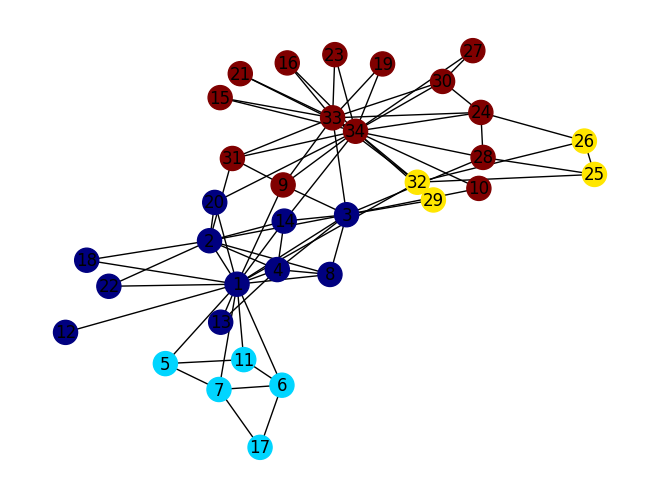

[0, 0, 0, 0, 1, 1, 1, 0, 3, 3]
Comunitati: 3
Modularity: 0.4151051939513475
Modularity Density: 7.544805194805195
Z Modularity: -0.4223989211402823


In [77]:
# 2. Karate
community("data/real/karate/karate.gml")

Comunitățile identificate:
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 3, 11: 1, 12: 1, 13: 1, 14: 1, 15: 3, 16: 3, 17: 1, 18: 1, 19: 3, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 0, 30: 4, 31: 4, 32: 1, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 2, 52: 2, 53: 1, 54: 1, 55: 3, 56: 1, 57: 1, 58: 2, 59: 4, 60: 4, 61: 4, 62: 4, 63: 4, 64: 2, 65: 2, 66: 4, 67: 2, 68: 2, 69: 2, 70: 4, 71: 4, 72: 4, 73: 4, 74: 4, 75: 4, 76: 4, 77: 4, 78: 4, 79: 4, 80: 4, 81: 4, 82: 4, 83: 4, 84: 4, 85: 2, 86: 4, 87: 4, 88: 4, 89: 4, 90: 4, 91: 4, 92: 4, 93: 4, 94: 4, 95: 4, 96: 4, 97: 4, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: 2, 104: 2}


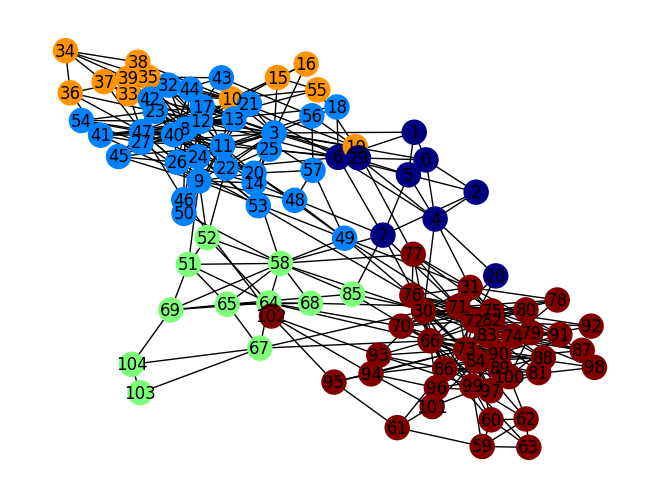

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Comunitati: 4
Modularity: 0.5267969621711297
Modularity Density: 20.995707070707073
Z Modularity: -0.6369925535644714


In [78]:
# 3. krebs
community("data/real/krebs/krebs.gml")

Comunitățile identificate:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 0, 5: 3, 6: 2, 7: 0, 8: 0, 9: 0, 10: 3, 11: 0, 12: 5, 13: 2, 14: 5, 15: 2, 16: 0, 17: 4, 18: 5, 19: 8, 20: 4, 21: 0, 22: 0, 23: 0, 24: 0, 25: 1, 26: 5, 27: 4, 28: 0, 29: 8, 30: 8, 31: 5, 32: 2, 33: 1, 34: 5, 35: 8, 36: 4, 37: 1, 38: 5, 39: 2, 40: 3, 41: 0, 42: 5, 43: 5, 44: 6, 45: 1, 46: 7, 47: 2, 48: 6, 49: 7, 50: 0, 51: 0, 52: 3, 53: 7, 54: 5, 55: 8, 56: 4, 57: 6, 58: 4, 59: 4, 60: 2, 61: 5, 62: 4, 63: 4, 64: 2, 65: 4, 66: 6, 67: 7, 68: 0, 69: 0, 70: 4, 71: 5, 72: 3, 73: 7, 74: 3, 75: 6, 76: 4, 77: 0, 78: 0, 79: 8, 80: 8, 81: 3, 82: 8, 83: 7, 84: 3, 85: 5, 86: 6, 87: 4, 88: 7, 89: 1, 90: 0, 91: 6, 92: 6, 93: 0, 94: 8, 95: 4, 96: 4, 97: 4, 98: 3, 99: 5, 100: 2, 101: 8, 102: 3, 103: 1, 104: 0, 105: 1, 106: 2, 107: 3, 108: 0, 109: 1, 110: 7, 111: 0, 112: 6, 113: 4, 114: 7}


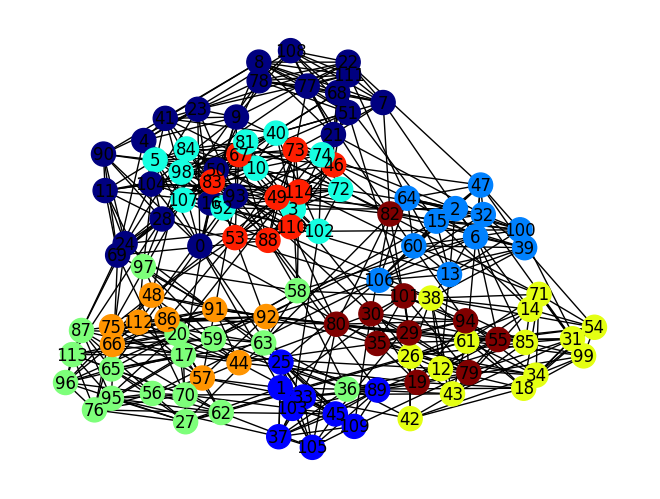

[0, 1, 2, 3, 0, 3, 2, 0, 0, 0]
Comunitati: 8
Modularity: 0.6037087765389424
Modularity Density: 41.93287496816908
Z Modularity: -0.2594927968519758


In [79]:
# 4. footbal
community("data/real/football/football.gml")

Comunitățile identificate:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 4, 25: 4, 26: 0, 27: 4, 28: 5, 29: 5, 30: 3, 31: 3, 32: 5, 33: 5, 34: 5, 35: 5, 36: 5, 37: 5, 38: 5, 39: 0, 40: 4, 41: 4, 42: 4, 43: 5, 44: 5, 45: 5, 46: 2, 47: 2, 48: 2, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 4, 69: 4, 70: 4, 71: 4, 72: 5, 73: 2, 74: 2, 75: 4, 76: 2}


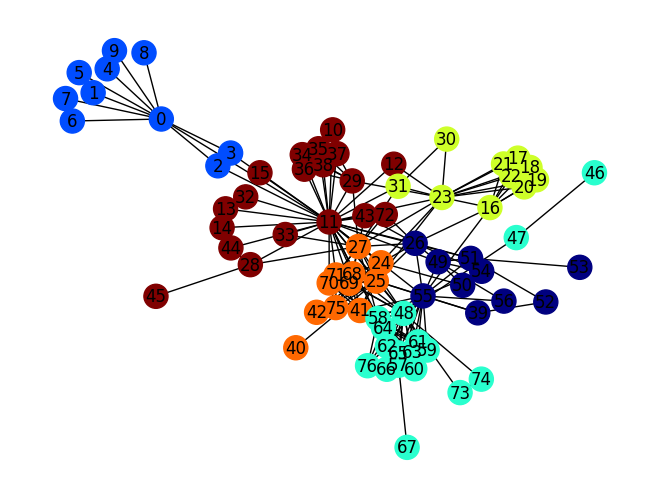

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Comunitati: 5
Modularity: 0.5582723665447354
Modularity Density: 20.0213059386434
Z Modularity: -0.4111573948308367


In [80]:
# 5. Les Miserables: coappearance network of characters in the novel Les Miserables. 
# Please cite D. E. Knuth, The Stanford GraphBase: A Platform for Combinatorial Computing, Addison-Wesley, Reading, MA (1993).
community("data/myData/lesMiserables/lesmis.gml")

Comunitățile identificate:
{0: 0, 1: 0, 2: 0, 3: 3, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 2, 29: 0, 30: 2, 31: 2, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 4, 49: 4, 50: 3, 51: 1, 52: 1, 53: 3, 54: 3, 55: 3, 56: 3, 57: 4, 58: 1, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 1, 65: 1, 66: 2, 67: 1, 68: 1, 69: 1, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 1, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 92: 2, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 2, 103: 1, 104: 1}


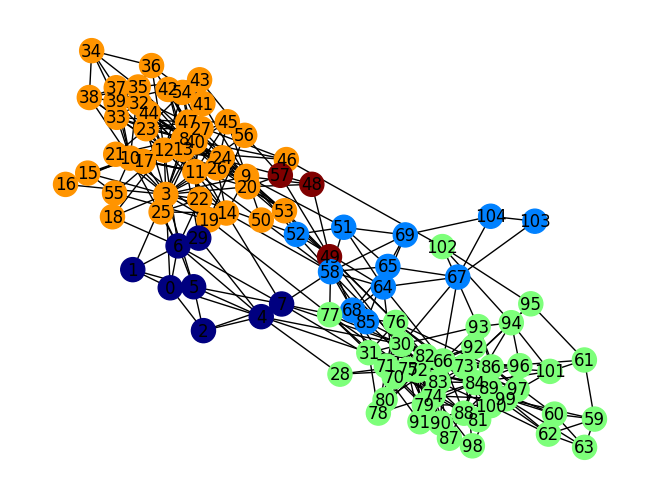

[0, 0, 0, 3, 0, 0, 0, 0, 3, 3]
Comunitati: 4
Modularity: 0.5267892493354298
Modularity Density: 18.96336184141062
Z Modularity: -0.7269562240672454


In [81]:
# 6.Books about US politics: A network of books about US politics published around the time of the 2004 presidential election and sold by the online bookseller Amazon.com.
# Edges between books represent frequent copurchasing of books by the same buyers. 
#  The network was compiled by V. Krebs and is unpublished, but can found on Krebs' web site. 
community("data/myData/politicalBooks/polBooks.gml")

Comunitățile identificate:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 3, 12: 4, 13: 5, 14: 5, 15: 2, 16: 5, 17: 6, 18: 4, 19: 5, 20: 5, 21: 4, 22: 5, 23: 5, 24: 5, 25: 3, 26: 3, 27: 6, 28: 1, 29: 6, 30: 1, 31: 6, 32: 2, 33: 1, 34: 1, 35: 3, 36: 5, 37: 6, 38: 2, 39: 2, 40: 3, 41: 0, 42: 0, 43: 6, 44: 4, 45: 0, 46: 3, 47: 5, 48: 2, 49: 5, 50: 4, 51: 2, 52: 2, 53: 4, 54: 4, 55: 5, 56: 3, 57: 2, 58: 6, 59: 3, 60: 3, 61: 3, 62: 3, 63: 6, 64: 6, 65: 6, 66: 6, 67: 5, 68: 5, 69: 3, 70: 5, 71: 3, 72: 6, 73: 0, 74: 6, 75: 2, 76: 2, 77: 2, 78: 4, 79: 6, 80: 6, 81: 6, 82: 6, 83: 6, 84: 6, 85: 0, 86: 6, 87: 5, 88: 2, 89: 1, 90: 0, 91: 0, 92: 1, 93: 0, 94: 5, 95: 1, 96: 1, 97: 0, 98: 6, 99: 1, 100: 6, 101: 3, 102: 4, 103: 6, 104: 3, 105: 5, 106: 2, 107: 1, 108: 5, 109: 6, 110: 6, 111: 0}


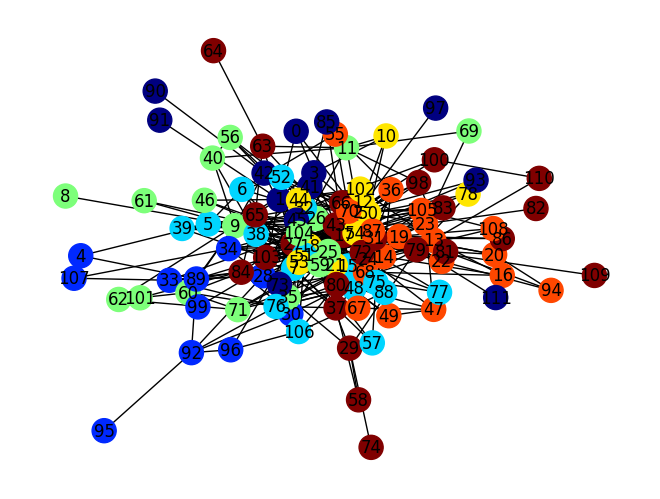

[0, 0, 0, 0, 1, 2, 2, 2, 3, 3]
Comunitati: 6
Modularity: 0.28645536332180094
Modularity Density: -5.595344276466568
Z Modularity: -0.3520338774528956


In [82]:
# 7. Word adjacencies: adjacency network of common adjectives and nouns in the novel David Copperfield by Charles Dickens.
# Please cite M. E. J. Newman, Phys. Rev. E 74, 036104 (2006).
community("data/mydata/wordAdjacencies/adjnoun.gml")

In [84]:
# 8.Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. 
# Data compiled by D. Watts and S. Strogatz and made available on the web here. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998).
community("data/myData/powerGrid/power.gml")

4941
[13, 1, 1, 2, 4, 4, 4, 4, 4, 4]
Comunitati: 38
Modularity: 0.9363462790816905
Modularity Density: 96.72279312359869
Z Modularity: -0.06966824624880252


Comunitățile identificate:
{0: 7, 1: 7, 2: 7, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 3, 31: 3, 32: 3, 33: 3, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 5, 41: 5, 42: 5, 43: 5, 44: 5, 45: 5, 46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 6, 59: 6, 60: 6, 61: 6, 62: 6, 63: 6, 64: 6, 65: 6, 66: 6, 67: 6, 68: 7, 69: 7, 70: 7, 71: 7, 72: 2, 73: 2, 74: 2, 75: 2, 76: 4, 77: 4, 78: 4, 79: 4, 80: 4, 81: 4, 82: 4, 83: 4, 84: 4, 85: 4, 86: 4, 87: 4}


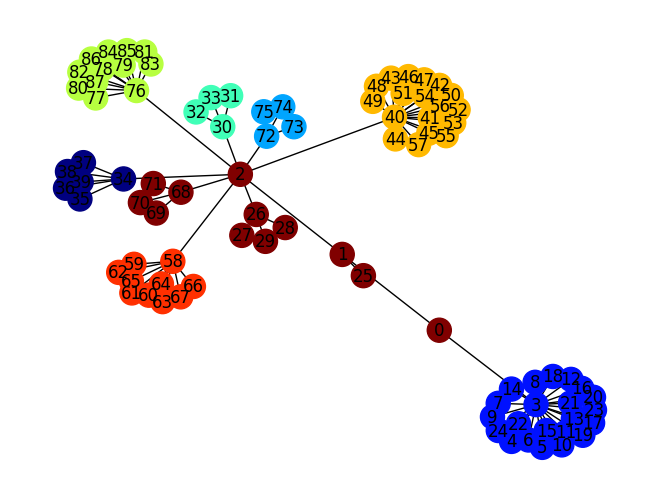

[7, 7, 7, 1, 1, 1, 1, 1, 1, 1]
Comunitati: 7
Modularity: 0.7536002113885477
Modularity Density: 12.396969696969697
Z Modularity: -0.26066537455082417


In [83]:
# 9. Lobster
community("data/myData/lobster/lobster.gml")

In [85]:
# 10. Internet: a symmetrized snapshot of the structure of the Internet at the level of autonomous systems, 
# reconstructed from BGP tables posted by the University of Oregon
community("data/myData/internet/as-22july06.gml")

22963
[0, 0, 1, 1, 35, 35, 35, 3, 3, 3]
Comunitati: 39
Modularity: 0.6597716301270365
Modularity Density: 79.74724031305065
Z Modularity: -0.15191230522574917


In [11]:
# Load the graph (example with an edge list)
G = nx.read_edgelist("data/myData/100.000/gplus_combined.txt")
# Calcularea partajării în comunități
partition = community_louvain.best_partition(G)
# Afișarea rezultatului
if len(partition) < 200:
    print("Comunitățile identificate:")
    print(partition)
    # Desenarea grafului cu noduri colorate în funcție de comunitate
    pos = nx.spring_layout(G)
    colors = [partition[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.jet)
    plt.show()
else: 
    print(len(partition))
# Transformarea dicționarului într-o listă
num_nodes = len(G.nodes())
community_list = [partition[node] for node in G.nodes()]

print(community_list[:10])
print("Comunitati:", max(community_list))
# Calcularea parametrilor pentru funcția modularity
noNodes = len(G.nodes)
mat = nx.to_numpy_array(G)
degrees = [val for (node, val) in G.degree()]
noEdges = G.number_of_edges()

# Parametrii pentru funcția modularity
params = {
    'noNodes': noNodes,
    'mat': mat,
    'degrees': degrees,
    'noEdges': noEdges
}

print("Modularity:", my_modularity(community_list, params))
print("Modularity Density:", modularity_density(community_list, params))
print("Z Modularity:", z_modularity(community_list, params))

107614
[0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Comunitati: 39


MemoryError: Unable to allocate 86.3 GiB for an array with shape (107614, 107614) and data type float64